# Bitcoin_Price_Prediction_Slide

### Let's get started:

# Step 1: Importing Libraries

In [51]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error
import tensorflow as tf
from keras import Model
from keras.layers import Input, Dense, Dropout
from keras.layers import LSTM
import datetime as dt

# Step 2: Reading Dataset

In [87]:
df = pd.read_csv('main.csv')

# Step 3: Dataset Overview

In [88]:
df.head(2)

Open Time      Open      High       Low     Close     Volume  \
0  1609459200000  28923.63  28961.66  28913.12  28961.66  27.457032   
1  1609459260000  28961.67  29017.50  28961.01  29009.91  58.477501   

      Close Time  Quote asset volume  Number of trades  \
0  1609459259999        7.943820e+05              1292   
1  1609459319999        1.695803e+06              1651   

   Taker buy base asset volume  Taker buy quote asset volume  
0                    16.777195                 485390.826825  
1                    33.733818                 978176.468202

In [89]:
df['Open Time'] = pd.to_datetime(df['Open Time'], unit='ms')
df['Close Time'] = pd.to_datetime(df['Close Time'], unit='ms')

__Dataset Basic Information:__

In [90]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188317 entries, 0 to 188316
Data columns (total 11 columns):
 #   Column                        Non-Null Count   Dtype         
---  ------                        --------------   -----         
 0   Open Time                     188317 non-null  datetime64[ns]
 1   Open                          188317 non-null  float64       
 2   High                          188317 non-null  float64       
 3   Low                           188317 non-null  float64       
 4   Close                         188317 non-null  float64       
 5   Volume                        188317 non-null  float64       
 6   Close Time                    188317 non-null  datetime64[ns]
 7   Quote asset volume            188317 non-null  float64       
 8   Number of trades              188317 non-null  int64         
 9   Taker buy base asset volume   188317 non-null  float64       
 10  Taker buy quote asset volume  188317 non-null  float64       
dtypes: datetime64

__All variables are stored as object.__

# Step 4: Data Preparation

## Step 4.1: Feature Subset Selection
__Since we will not use some characteristics to predict price, we will discard these characteristics__

In [91]:
df.drop(['Close Time'
        , 'Quote asset volume'
        , 'Number of trades'
        , 'Taker buy base asset volume'
        , 'Taker buy quote asset volume'
        , 'Volume'], axis=1, inplace=True)

In [92]:
df.head(2)

Open Time      Open      High       Low     Close
0 2021-01-01 00:00:00  28923.63  28961.66  28913.12  28961.66
1 2021-01-01 00:01:00  28961.67  29017.50  28961.01  29009.91

## Step 4.2: Transforming Data

__Date feature is stored as object in the data frame. To increase the speed of calculations, we convert it's data type to datetime and then sort this feature in ascending order:__

In [93]:
df['Open Time'] = pd.to_datetime(df['Open Time'])
df.sort_values(by='Open Time', ascending=True, inplace=True)
df.reset_index(drop=True, inplace=True)

__Result:__

In [95]:
df.head(2)

Open Time      Open      High       Low     Close
0 2021-01-01 00:00:00  28923.63  28961.66  28913.12  28961.66
1 2021-01-01 00:01:00  28961.67  29017.50  28961.01  29009.91

## Step 4.3: Checking Duplicates
__There are no duplicate samples in Date feature:__

In [96]:
df.duplicated().sum()

0

## Step 4.4: Checking Missing Values
__There are no missing values in the dataset:__

In [97]:
df.isnull().sum().sum()

0

In [103]:
df = df.rename(columns={"Close": "Price", "Open Time": "Date"})

In [104]:
df.head(2)

Date      Open      High       Low     Price
0 2021-01-01 00:00:00  28923.63  28961.66  28913.12  28961.66
1 2021-01-01 00:01:00  28961.67  29017.50  28961.01  29009.91

# Step 5: Visualizing Bitcoin Price History Data

__Interactive Gold Price Chart:__

In [106]:
fig = px.line(y=df.Price, x=df.Date)
fig.update_traces(line_color='black') 
fig.update_layout(xaxis_title="Date", 
                  yaxis_title="Scaled Price",
                  title={'text': "Gold Price History Data", 'y':0.95, 'x':0.5, 'xanchor':'center', 'yanchor':'top'},
                  plot_bgcolor='rgba(255,223,0,0.8)')

# Step 6: Splitting Data to Training & Test Sets

In [107]:
test_size = df[df.Date.dt.month==5].shape[0]
test_size

16120

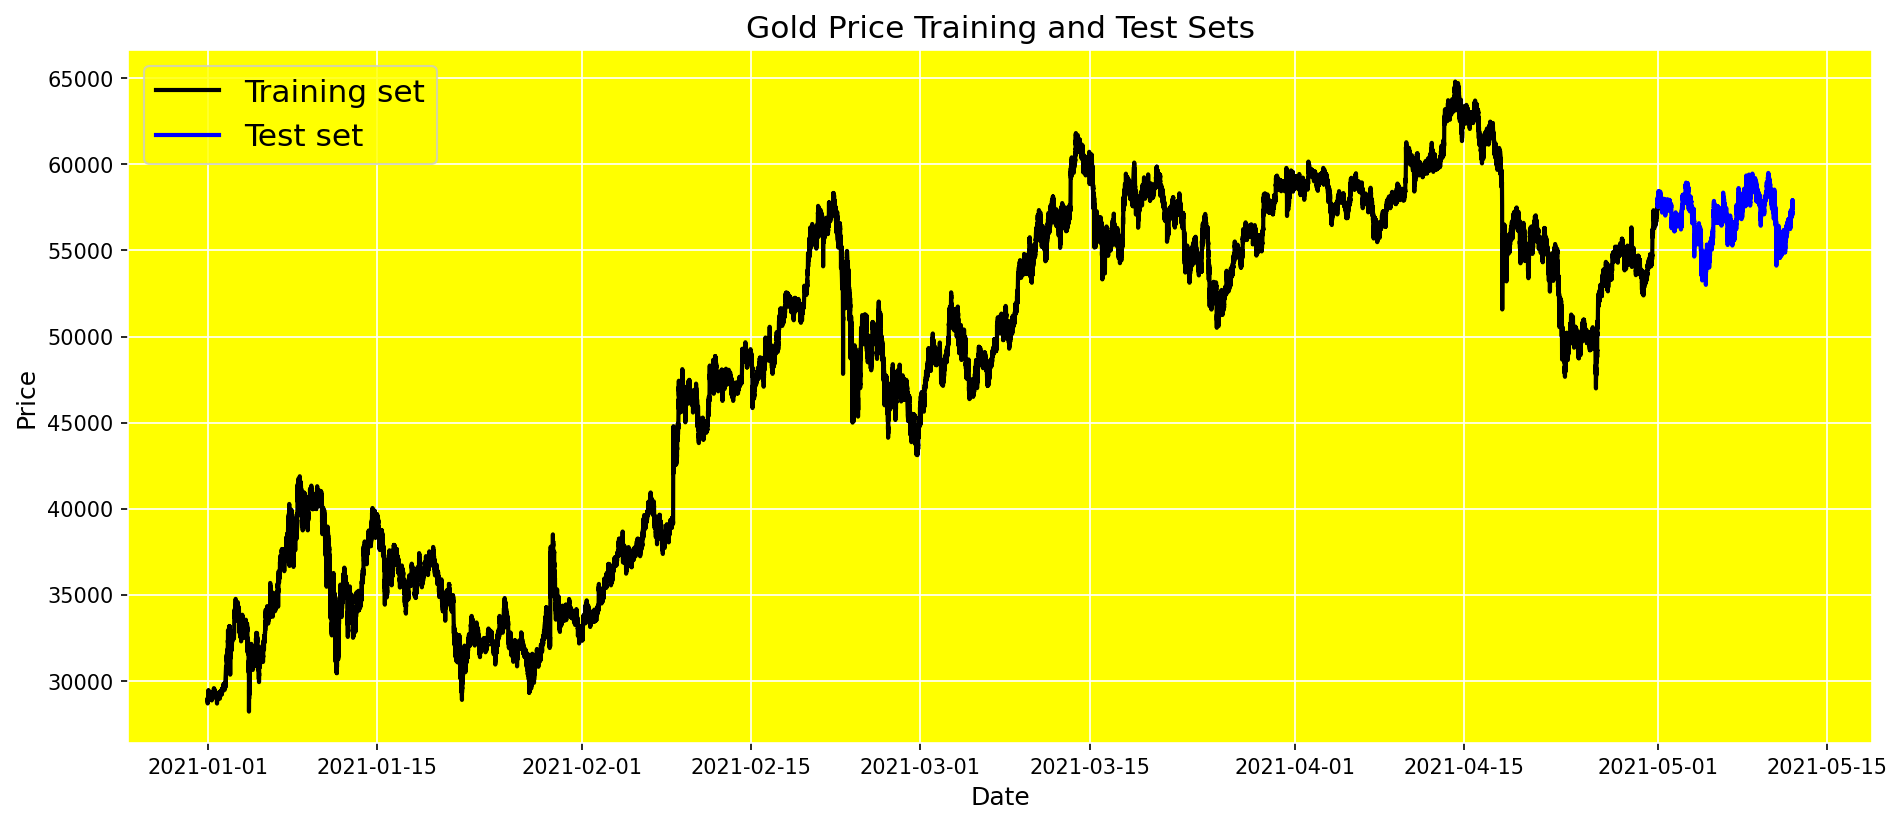

In [108]:
plt.figure(figsize=(15, 6), dpi=150)
plt.rcParams['axes.facecolor'] = 'yellow'
plt.rc('axes',edgecolor='white')
plt.plot(df.Date[:-test_size], df.Price[:-test_size], color='black', lw=2)
plt.plot(df.Date[-test_size:], df.Price[-test_size:], color='blue', lw=2)
plt.title('Gold Price Training and Test Sets', fontsize=15)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.legend(['Training set', 'Test set'], loc='upper left', prop={'size': 15})
plt.grid(color='white')
plt.show()

# Step 7: Data Scaling
__Since we aim to predict Price only based on its historical data, we scale Price using MinMaxScaler to avoid intensive computations:__

In [109]:
scaler = MinMaxScaler()
scaler.fit(df.Price.values.reshape(-1,1))

MinMaxScaler()

# Step 8: Restructure Data & Create Sliding Window
__The use of prior time steps to predict the next time step is called sliding window. In this way, time series data can be expressed as supervised learning. We can do this by using previous time steps as input variables and use the next time step as the output variable. The number of previous time steps is called the window width. Here we set window width to 60. Therefore, X_train and X_test will be nested lists containing lists of 60 time-stamp prices. y_train and y_test are also lists of gold prices containing the next day's gold price corresponds to each list in X_train and X_test respectively:__

In [110]:
window_size = 60

__Training Set:__

In [111]:
train_data = df.Price[:-test_size]
train_data = scaler.transform(train_data.values.reshape(-1,1))

In [112]:
train_data

array([[0.0198605 ],
       [0.02118009],
       [0.02061643],
       ...,
       [0.80771283],
       [0.80630272],
       [0.80566604]])

In [113]:
X_train = []
y_train = []

for i in range(window_size, len(train_data)):
    X_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])

__Test Set:__

In [114]:
df.Price

0         28961.66
1         29009.91
2         28989.30
3         28982.69
4         28975.65
            ...   
188312    57485.07
188313    57481.49
188314    57470.00
188315    57450.90
188316    57450.19
Name: Price, Length: 188317, dtype: float64

In [115]:
test_data = df.Price[-test_size-60:]
test_data = scaler.transform(test_data.values.reshape(-1,1))

In [116]:
X_test = []
y_test = []

for i in range(window_size, len(test_data)):
    X_test.append(test_data[i-60:i, 0])
    y_test.append(test_data[i, 0])

# Step 9: Converting Data to Numpy Arrays

__Now X_train and X_test are nested lists (two-dimensional lists) and y_train is a one-dimensional list. We need to convert them to numpy arrays with a higher dimension, which is the data format accepted by TensorFlow when training the neural network:__

In [117]:
X_train = np.array(X_train)
X_test  = np.array(X_test)
y_train = np.array(y_train)
y_test  = np.array(y_test)

In [118]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test  = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
y_train = np.reshape(y_train, (-1,1))
y_test  = np.reshape(y_test, (-1,1))

In [119]:
print('X_train Shape: ', X_train.shape)
print('y_train Shape: ', y_train.shape)
print('X_test Shape:  ', X_test.shape)
print('y_test Shape:  ', y_test.shape)

X_train Shape:  (172137, 60, 1)
y_train Shape:  (172137, 1)
X_test Shape:   (16120, 60, 1)
y_test Shape:   (16120, 1)


# Step 10: Creating an LSTM Network 
__We build an LSTM network, which is a type of Recurrent Neural Networks designed to solve vanishing gradient problem:__

__Model Definition:__

In [120]:
def define_model():
    input1 = Input(shape=(window_size,1))
    x = LSTM(units = 64, return_sequences=True)(input1)  
    x = Dropout(0.2)(x)
    x = LSTM(units = 64, return_sequences=True)(x)
    x = Dropout(0.2)(x)
    x = LSTM(units = 64)(x)
    x = Dropout(0.2)(x)
    x = Dense(32, activation='softmax')(x)
    dnn_output = Dense(1)(x)

    model = Model(inputs=input1, outputs=[dnn_output])
    model.compile(loss='mean_squared_error', optimizer='Adam')
    model.summary()
    
    return model

__Model Training:__

In [121]:
model = define_model()
history = model.fit(X_train, y_train, epochs=15, batch_size=32, validation_split=0.1, verbose=1)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 60, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 60, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 60, 64)         │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 60, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 85,057 (332.25 KB)

 Trainable params: 85,057 (332.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
4842/4842 ━━━━━━━━━━━━━━━━━━━━ 565s 115ms/step - loss: 0.0825 - val_loss: 0.0349
Epoch 2/15
4842/4842 ━━━━━━━━━━━━━━━━━━━━ 567s 117ms/step - loss: 0.0788 - val_loss: 0.0339
Epoch 3/15
4842/4842 ━━━━━━━━━━━━━━━━━━━━ 594s 123ms/step - loss: 0.0366 - val_loss: 1.3571e-04
Epoch 4/15
4842/4842 ━━━━━━━━━━━━━━━━━━━━ 546s 113ms/step - loss: 2.5177e-04 - val_loss: 1.4772e-04
Epoch 5/15
4842/4842 ━━━━━━━━━━━━━━━━━━━━ 555s 115ms/step - loss: 1.6380e-04 - val_loss: 2.8557e-05
Epoch 6/15
4842/4842 ━━━━━━━━━━━━━━━━━━━━ 470s 97ms/step - loss: 1.0073e-04 - val_loss: 2.7762e-05
Epoch 7/15
4842/4842 ━━━━━━━━━━━━━━━━━━━━ 454s 94ms/step - loss: 7.5946e-05 - val_loss: 1.3424e-04
Epoch 8/15
4842/4842 ━━━━━━━━━━━━━━━━━━━━ 454s 94ms/step - loss: 6.2930e-05 - val_loss: 2.1833e-05
Epoch 9/15
4842/4842 ━━━━━━━━━━━━━━━━━━━━ 454s 94ms/step - loss: 5.2236e-05 - val_loss: 1.3312e-05
Epoch 10/15
4842/4842 ━━━━━━━━━━━━━━━━━━━━ 473s 98ms/step - loss: 4.5880e-05 - val_loss: 3.8989e-05
Epoch 11/15
4842/4842 ━━

# Step 11: Model Evaluation
__Next, we evaluate our time series forecast using MAPE (Mean Absolute Percentage Error) metric:__

In [122]:
result = model.evaluate(X_test, y_test)
y_pred = model.predict(X_test) 

504/504 ━━━━━━━━━━━━━━━━━━━━ 22s 44ms/step - loss: 1.2764e-05
504/504 ━━━━━━━━━━━━━━━━━━━━ 22s 42ms/step


In [123]:
MAPE = mean_absolute_percentage_error(y_test, y_pred)
Accuracy = 1 - MAPE

In [124]:
print("Test Loss:", result)
print("Test MAPE:", MAPE)
print("Test Accuracy:", Accuracy)

Test Loss: 1.7318374375463463e-05
Test MAPE: 0.004092801949358653
Test Accuracy: 0.9959071980506413


# Step 12: Visualizing Results

__Returning the actual and predicted Price values to their primary scale:__

In [125]:
y_test_true = scaler.inverse_transform(y_test)
y_test_pred = scaler.inverse_transform(y_pred)

__Investigating the closeness of the prices predicted by the model to the actual prices:__

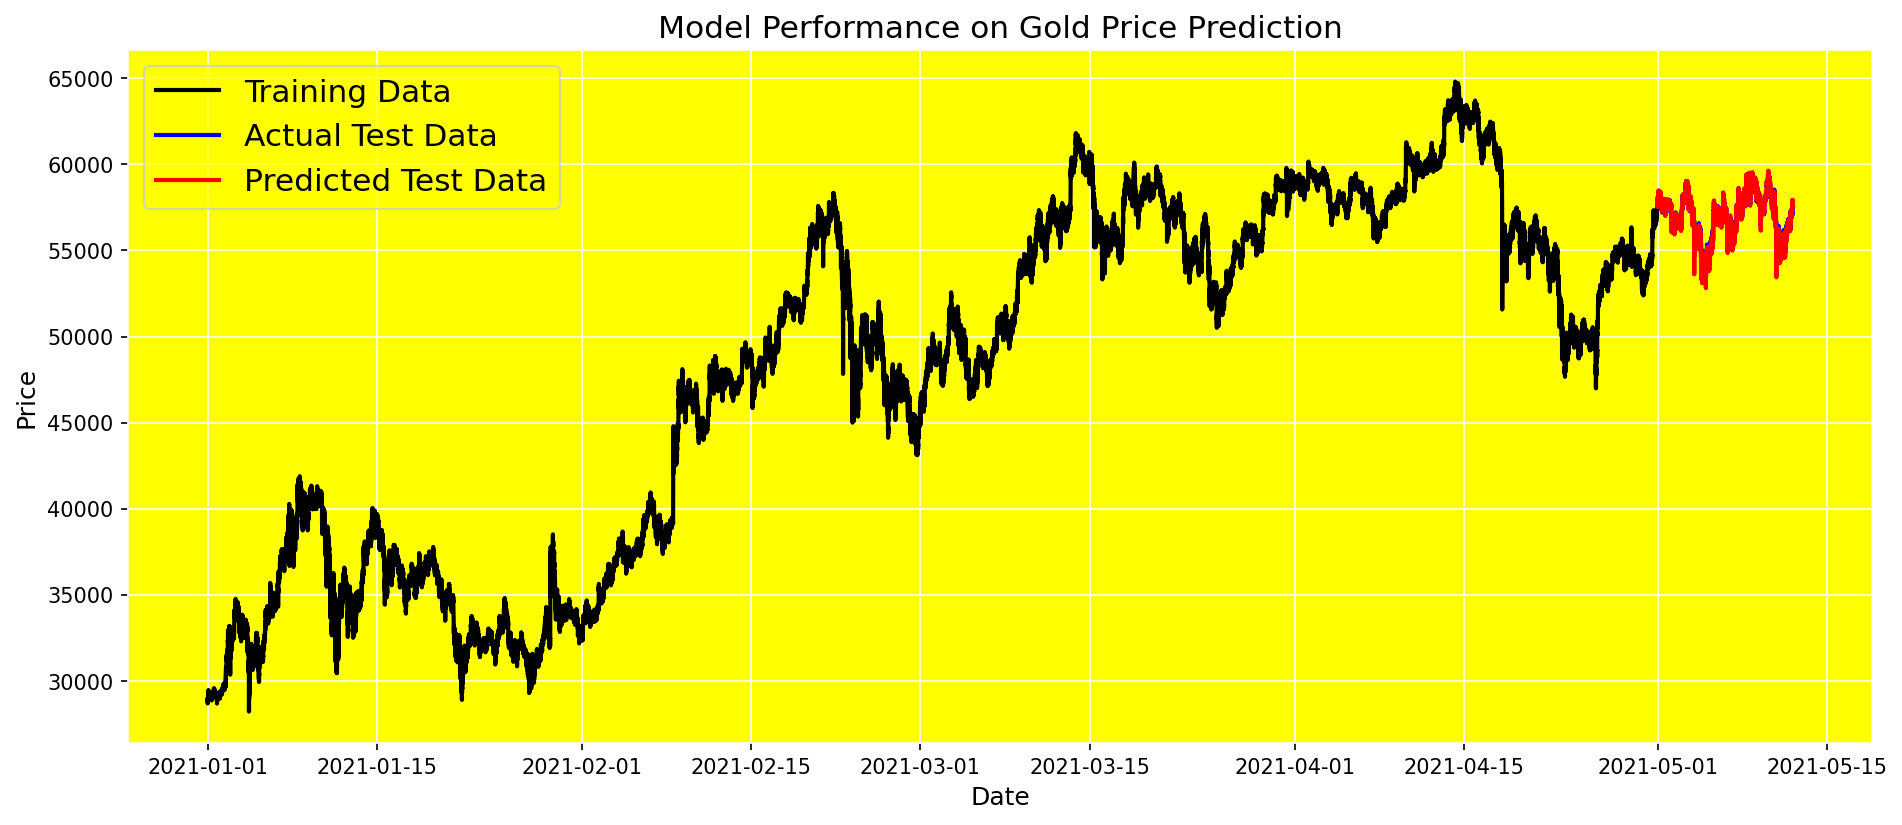

In [126]:
plt.figure(figsize=(15, 6), dpi=150)
plt.rcParams['axes.facecolor'] = 'yellow'
plt.rc('axes',edgecolor='white')
plt.plot(df['Date'].iloc[:-test_size], scaler.inverse_transform(train_data), color='black', lw=2)
plt.plot(df['Date'].iloc[-test_size:], y_test_true, color='blue', lw=2)
plt.plot(df['Date'].iloc[-test_size:], y_test_pred, color='red', lw=2)
plt.title('Model Performance on Gold Price Prediction', fontsize=15)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.legend(['Training Data', 'Actual Test Data', 'Predicted Test Data'], loc='upper left', prop={'size': 15})
plt.grid(color='white')
plt.show()